<a href="https://colab.research.google.com/github/OmPanchal/GoogLeNet-using-tensorflow/blob/main/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **[GoogLeNet](https://arxiv.org/pdf/1409.4842.pdf)**

**Initial Thoughts - Before reading paper**

After a quick overview of the paper, the attributes of the model and training that seem to stand out include:
* **The Inception Module:** A "layer" which consists of convlutions with different kernels sizes. Assuming that a copy of the input passes through each of the layers in the module, the output is likely to be a stack of all of the outputs.
* **Auxiliary Classifiers:** Intermediate outputs, where the loss of each is taken and added to the total loss.

**After Reading the Paper**
* The size of the dataset will obviously need to be reduced, therefore this model will be trained on the tiny imagenet dataset.

Overall the design of the model seems to be simple therefore there aren't any new methods to learn. As a result, this model will be trained on a subset of images from the tiny imagenet dataset, with training parameters kept as close to the paper as possible

## **Imports**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle

## **Functions**

In [2]:
def list_full_dir(path):
    return list(map(lambda x: os.path.join(path, x), os.listdir(path)))

## **Data - Tiny ImageNet**

In [3]:
# Download the dataset from kaggle
dataset_path = "akash2sharma/tiny-imagenet"
dataset_name = "tiny-imagenet"

!pip install kaggle --quiet

!mkdir ~/.kaggle/
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d {dataset_path} --quiet

!mkdir data
!unzip -qq {dataset_name + ".zip"} -d data

Dataset URL: https://www.kaggle.com/datasets/akash2sharma/tiny-imagenet
License(s): unknown


In [4]:
!rm -r /content/data/tiny-imagenet-200/tiny-imagenet-200
!rm -r /content/tiny-imagenet.zip

In [11]:
TRAIN_IMAGES_PATH = "/content/data/tiny-imagenet-200/train"
VALIDATION_IMAGES_PATH = "/content/data/tiny-imagenet-200/validation"
TEST_IMAGES_PATH = "/content/data/tiny-imagenet-200/test"

In [6]:
labels_list = os.listdir("/content/data/tiny-imagenet-200/train")

with open("/content/data/tiny-imagenet-200/words.txt", "r") as f:
    text = f.readlines()
    train_mapping = {}

    for t in text:
        id, la = t.split("\t")

        if id in labels_list:
            train_mapping[id] = la.strip()

LABELS = list(train_mapping.values())

In [7]:
TRAIN = tf.keras.utils.image_dataset_from_directory("/content/data/tiny-imagenet-200/train").unbatch()
TRAIN = TRAIN.map(lambda im, la: (im / 255., tf.one_hot(la, depth=200)))
TRAIN = TRAIN.batch(32)

Found 100000 files belonging to 200 classes.


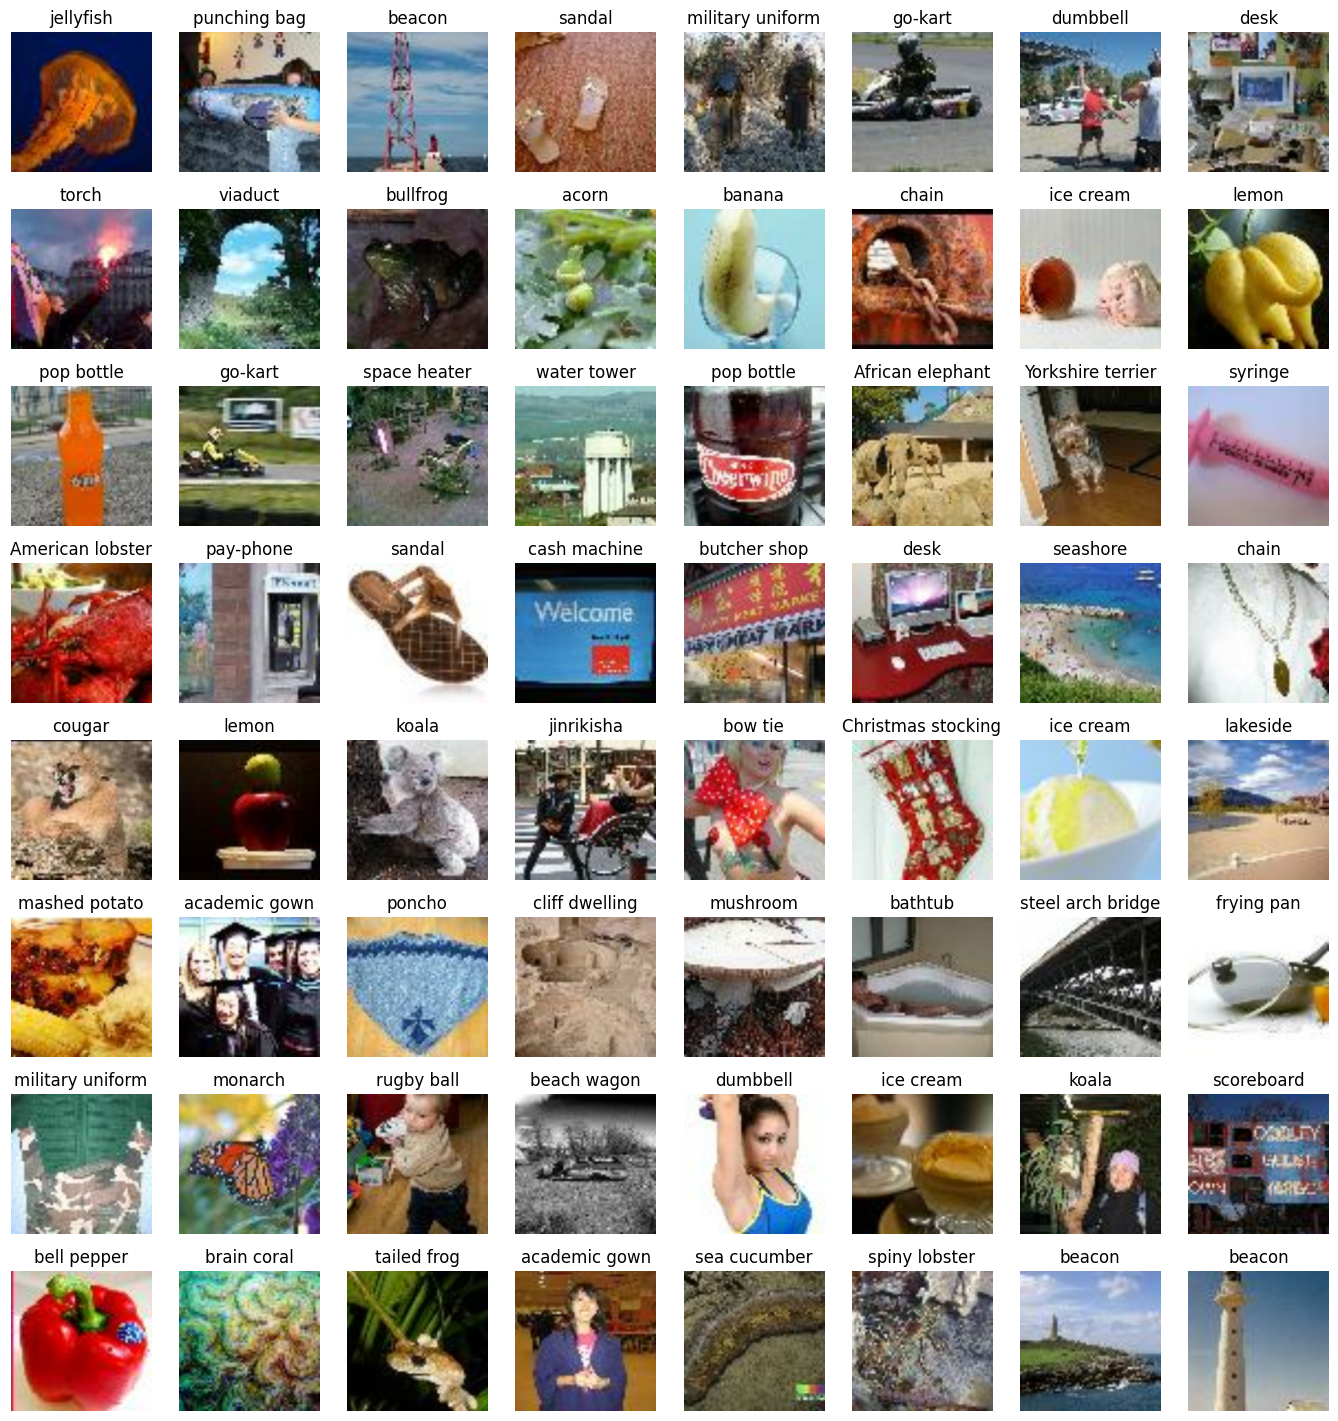

In [8]:
train_image_sample = next(TRAIN.unbatch().batch(64).take(1).as_numpy_iterator())

sample_images = np.reshape(train_image_sample[0], newshape=(8, 8, 256, 256, 3))
sample_labels = np.reshape(train_image_sample[1], newshape=(8, 8, 200))

train_image_sample[1].shape
fig1, ax1 = plt.subplots(8, 8)
fig1.set_figwidth(17)
fig1.set_figheight(18)

for i in range(8):
    for j in range(8):
        ax1[i, j].axis("off")
        ax1[i, j].title.set_text(LABELS[tf.where(sample_labels[i, j] == 1)[0][0]].split(",")[0])
        ax1[i, j].imshow(sample_images[i, j])

plt.show()

In [9]:
if os.path.exists("/content/data/tiny-imagenet-200/val"):
    with open("/content/data/tiny-imagenet-200/val/val_annotations.txt", "r") as f:
        val_mapping = dict(map(lambda x: x.split("\t")[0:2], f.readlines()))

    unique_ids = set(val_mapping.values())

    if not os.path.exists(VALIDATION_IMAGES_PATH):
        os.mkdir(VALIDATION_IMAGES_PATH)

        for id in unique_ids:
            os.mkdir(os.path.join(VALIDATION_IMAGES_PATH, id))

    for image_path in list_full_dir("/content/data/tiny-imagenet-200/val/images"):
        file_name = image_path.split("/")[-1]
        os.replace(image_path, os.path.join(VALIDATION_IMAGES_PATH, val_mapping[file_name], file_name))

    shutil.rmtree("/content/data/tiny-imagenet-200/val")

VALIDATION = tf.keras.utils.image_dataset_from_directory(VALIDATION_IMAGES_PATH).unbatch()
VALIDATION = VALIDATION.map(lambda im, la: (im / 255., tf.one_hot(la, depth=200)))
VALIDATION = VALIDATION.batch(32).prefetch(16)

Found 10000 files belonging to 200 classes.


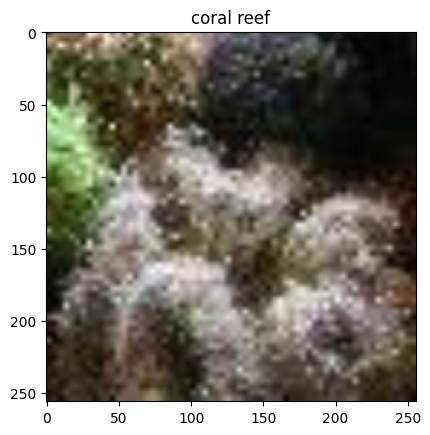

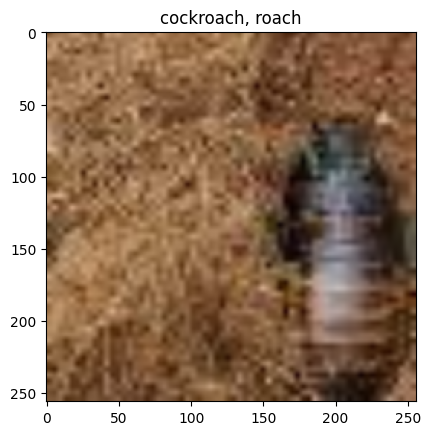

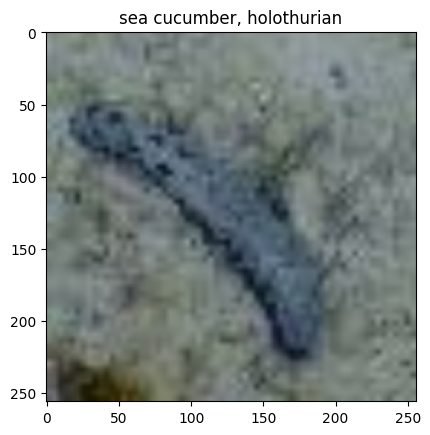

In [10]:
validation_sample_image, validation_sample_label = next(VALIDATION.unbatch().batch(3).take(1).as_numpy_iterator())

for i, l in zip(validation_sample_image, validation_sample_label) :
    plt.title(LABELS[tf.where(l == 1)[0][0]])
    plt.imshow(i)
    plt.show()

## **Model Internals**

### Inception Module initial build

In [ ]:
class InceptionModuleTest(tf.keras.layers.Layer):
    def __init__(self,
                 x1_filters,
                 x3r_filters,
                 x3_filters,
                 x5r_filters,
                 x5_filters,
                 pool_proj,
                 activation="relu"):
        self.conv1 = tf.keras.layers.Convolution2D(x1_filters, (1, 1),
                                            padding="same",
                                            activation=activation)

        self.conv3r = tf.keras.layers.Convolution2D(x3r_filters, (1, 1),
                                             padding="same",
                                             activation=activation)
        self.conv3 = tf.keras.layers.Convolution2D(x3_filters, (3, 3),
                                            padding="same",
                                            activation=activation)


        self.conv5r = tf.keras.layers.Convolution2D(x5r_filters, (1, 1),
                                             padding="same",
                                             activation=activation)
        self.conv5 = tf.keras.layers.Convolution2D(x5_filters, (5, 5),
                                            padding="same",
                                            activation=activation)


        self.max = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                             strides=(1, 1),
                                             padding="same")
        self.maxr = tf.keras.layers.Convolution2D(pool_proj, (1, 1),
                                             padding="same",
                                             activation=activation)
        self.concat = tf.keras.layers.Concatenate()
        super().__init__()

    def call(self, x):
        out_conv1 = self.conv1(x)
        out_conv3 = self.conv3(self.conv3r(x))
        out_conv5 = self.conv5(self.conv5r(x))
        out_max = self.maxr(self.max(x))

        return self.concat([out_conv1, out_conv3, out_conv5, out_max])

# inception_module_test_images, inception_module_test_labels = next(TRAIN.as_numpy_iterator())
inception_module_test_layer = InceptionModuleTest(64, 96, 128, 16, 32, 32)

In [ ]:
out = inception_module_test_layer(tf.random.uniform(shape=(32, 128, 128, 192)))

In [ ]:
out.shape

TensorShape([32, 28, 28, 256])

In [ ]:
sum = 0

for l in inception_module_test_layer.trainable_variables:
    sum += 32 * l.numpy().size

print(sum / 1e9, "GB")

0.003980288 GB


### **Inception Module**

The inception module aims to achieve multi level feature extraction by allowing for multiple filter sizes to be used during convolutions. In the paper, the input is convolved using 1x1, 3x3 and 5x5 filters, as well as an additional 3x3 max pooling layer. The outputs of these operations are then concatenated to give the filter concatenation. However, since these operations can be expensive computationally and in terms of RAM, 1x1 convolutions are used for (1) dimensionality reduction (leads to less operations) and (2) to introduce another non-linearity (the model has another set of parameters to train and apply to the intput)  

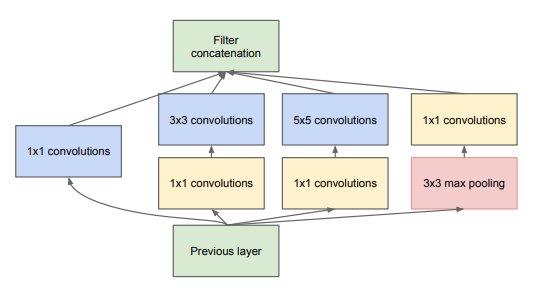

In [ ]:
class InceptionModule(tf.keras.layers.Layer):
    def __init__(self,
                 x1_filters,
                 x3r_filters,
                 x3_filters,
                 x5r_filters,
                 x5_filters,
                 pool_proj,
                 activation="relu"):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(x1_filters, (1, 1),
                                            padding="SAME",
                                            activation=activation)

        self.conv3r = tf.keras.layers.Conv2D(x3r_filters, (1, 1),
                                             padding="SAME",
                                             activation=activation)

        self.conv3 = tf.keras.layers.Conv2D(x3_filters, (3, 3),
                                            padding="SAME",
                                            activation=activation)


        self.conv5r = tf.keras.layers.Conv2D(x5r_filters, (1, 1),
                                             padding="SAME",
                                             activation=activation)
        self.conv5 = tf.keras.layers.Conv2D(x5_filters, (5, 5),
                                            padding="SAME",
                                            activation=activation)


        self.max = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                             strides=(1, 1),
                                             padding="SAME")
        self.maxr = tf.keras.layers.Conv2D(pool_proj, (1, 1),
                                             padding="SAME",
                                             activation=activation)
        self.concat = tf.keras.layers.Concatenate()

    def call(self, x):
        out_conv1 = self.conv1(x)
        out_conv3 = self.conv3(self.conv3r(x))
        out_conv5 = self.conv5(self.conv5r(x))
        out_max = self.maxr(self.max(x))

        return self.concat([out_conv1, out_conv3, out_conv5, out_max])

### **Local Response Normalisation**

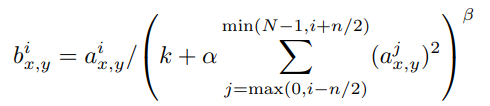

> *The constants k, n, α, and β are hyper-parameters whose values are determined using a validation set; we used k = 2, n = 5, α = 10−4, and β = 0.75.*

In [ ]:
class LocalResponseNormalisation(tf.keras.layers.DepthwiseConv2D):
    def __init__(self, k=2, n=5, alpha=10e-4, beta=.75, **kwargs):
        super().__init__(kernel_size=(n, 1),
                         strides=1,
                         padding="SAME",
                         depthwise_initializer='ones',
                         use_bias=False,
                         **kwargs
                         )
        self.n = n
        self.k = k
        self.alpha = alpha
        self.beta = beta
        self.trainable = False

    def build(self, input_shape):
        super().build(input_shape)
        self.depthwise_kernel = tf.ones(shape=(self.n, 1, input_shape[1], 1))

    def call(self, x):
        denom_sum = tf.transpose(super().call(tf.transpose(x, [0, 3, 2, 1]) ** 2), [0, 3, 2, 1])
        denom = (self.k + (self.alpha * denom_sum)) ** self.beta
        return x / denom


### **Auxilery Output**

> The exact structure of the extra network on the side, including the auxiliary classifier, is as follows:
* An average pooling layer with 5×5 filter size and stride 3, resulting in an 4×4×512 output for the (4a), and 4×4×528 for the (4d) stage.
* A 1×1 convolution with 128 filters for dimension reduction and rectified linear activation.
* A fully connected layer with 1024 units and rectified linear activation.
* A dropout layer with 70% ratio of dropped outputs.
* A linear layer with softmax loss as the classifier (predicting the same 1000 classes as the
main classifier, but removed at inference time).

However in this case, for the final point, there will be 200 classes to predict. The use of auxilery outputs is to ensure that

In [ ]:
class AuxileryOutput(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.a1 = tf.keras.layers.AveragePooling2D(pool_size=(5, 5), strides=3)
        self.x1 = tf.keras.layers.Convolution2D(128,
                                                kernel_size=(1, 1),
                                                activation="relu")
        self.f1 = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(1024, activation="relu")
        self.dr = tf.keras.layers.Dropout(0.7)
        self.d2 = tf.keras.layers.Dense(200, activation="softmax")

    def call(self, x):
        x = self.a1(x)
        x = self.x1(x)
        x = self.f1(x)
        x = self.d1(x)
        x = self.dr(x)
        return self.d2(x)

### **Model Architecture**
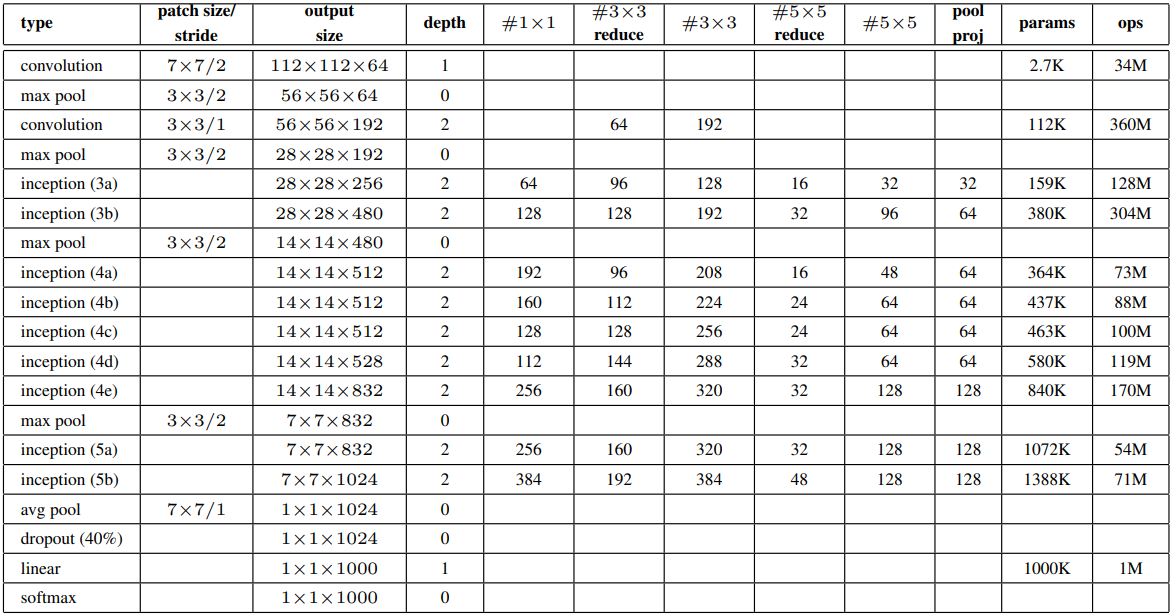

In [ ]:
class GoogLeNet(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.pre = tf.keras.layers.RandomCrop(224, 224)

        self.c1 = tf.keras.layers.Conv2D(filters=64,
                                         kernel_size=(7, 7),
                                         strides=(2, 2),
                                         padding="SAME")

        self.m1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.lrn1 = LocalResponseNormalisation()

        self.c2  = tf.keras.layers.Conv2D(filters=64,
                                          kernel_size=(1, 1),
                                          strides=(1, 1),
                                          padding="VALID")

        self.c3  = tf.keras.layers.Conv2D(filters=192,
                                          kernel_size=(3, 3),
                                          strides=(1, 1),
                                          padding="VALID")

        self.lrn2 = LocalResponseNormalisation()

        self.m2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception3a = InceptionModule(64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(128, 128, 192, 32, 96, 64)

        self.m3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception4a = InceptionModule(192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(160, 112, 224, 24, 64, 64)

        self.aux1 = AuxileryOutput()

        self.inception4c = InceptionModule(128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(256, 260, 320, 32, 128, 128)

        self.aux2 = AuxileryOutput()

        self.m4 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception5a = InceptionModule(256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(384, 192, 384, 48, 128, 128)

        self.a1 = tf.keras.layers.AveragePooling2D(pool_size=(7, 7),
                                                   strides=(1, 1))

        self.flatten = tf.keras.layers.Flatten()

        self.drop1 = tf.keras.layers.Dropout(0.4)

        self.d1 = tf.keras.layers.Dense(200, activation="softmax")

    def call(self, x):
        x = self.pre(x)

        x = self.c1(x)
        x = self.m1(x)
        x = self.lrn1(x)

        x = self.c2(x)
        x = self.c3(x)
        x = self.lrn2(x)

        x = self.m2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)

        x = self.m3(x)
        x = self.inception4a(x)
        a1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        a2 = self.aux2(x)

        x = self.inception4e(x)

        x = self.m4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.a1(x)
        x = self.flatten(x)
        x = self.drop1(x)

        return [self.d1(x), a2, a1]

googlenet = GoogLeNet()
# googlenet = tf.keras.models.load_model("/content/drive/MyDrive/GoogLeNet-Test-5")

### **Model Training**

#### **`GoogLeNetTrainer`**

In [16]:
# constants
INITIAL_LEARNING_RATE = 0.00005
TRAINING_SUBSET_SIZE = 10000
VALIDATION_SUBSET_SIZE = 1000

In [17]:
def lr_scheduler(epoch, lr):
    return INITIAL_LEARNING_RATE * (0.96 ** (epoch // 4))


class GoogLeNetTrainer():
    def __init__(self,
                checkpoint_path,
                batch_size=128,
                optimiser=None,
                loss=None,
                lr_schedule=None,
                metrics=None,
                train_subset=20000,
                validation_subset=1000,
            ):

        self.BATCH_SIZE = batch_size
        # Learning Rate is calculated based on the number of epochs...
        # The learning rate below is not the initial learning rate
        self.OPTIMISER = optimiser or tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)
        self.LOSS = loss or tf.keras.losses.categorical_crossentropy

        self.METRICS = [
                tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top-5"),
                tf.keras.metrics.TopKCategoricalAccuracy(k=1, name="top-1"),
                ]

        self.LR_SCHEDULER = lr_schedule or lr_scheduler

        self.CALLBACKS = [
            tf.keras.callbacks.LearningRateScheduler(schedule=lr_scheduler),
            tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
            tf.keras.callbacks.EarlyStopping(patience=3),
            ]

        self.TRAIN_SUBSET = train_subset
        self.VALIDATION_SUBSET = validation_subset

    def train(self, model, epochs=1, **kwargs):
        model.compile(
            optimizer=self.OPTIMISER,
            loss=[self.LOSS, self.LOSS, self.LOSS],
            metrics=self.METRICS,
            #             main,  a1,   a2
            loss_weights=[0.75, 0.15, 0.1]
        )

        model.fit(TRAIN.unbatch().batch(self.BATCH_SIZE).take(self.TRAIN_SUBSET),
                  initial_epoch=kwargs.get("initial_epoch") or 0,
                  epochs=epochs,
                  verbose=1,
                  callbacks=self.CALLBACKS,
                  validation_data=VALIDATION.unbatch().batch(self.BATCH_SIZE).take(self.VALIDATION_SUBSET),
                  use_multiprocessing=True,
                  )


# trainer = GoogLeNetTrainer(
#     train_subset=TRAINING_SUBSET_SIZE,
#     validation_subset=VALIDATION_SUBSET_SIZE
# )

# trainer.train(googlenet)

### **Issues/Fixes**

After various attempts at trying to train the model, all of them are only partially successful at generalising. The validation loss at the beginning of training hints at successful learning, however as training continues, the model clearly ends up overfitting (performance on the validation data is poor but not the training data.). This is as expected, however, due to the large size of the model.

A list of regularistaion techniques that my be applicible to this project are:
* L1 Regularisation
* L2 Regularisation
* Dropout Technique - Already used in the model, however may add more layers or increases the dropout rate.
* Transfer learning - A set of the first layers will be initialised with the googlenet layers while the last ones will be trained to fit the dataset.

#### **Implementing L1 and l2 Regularisation**

#### **Additional Dropout**



##### **Test 1**
* 2 Dropout layers with a rate of 0.6 will be added after each Local Response Normalisation Layers
* 4 Dropout layers with a rate of 0.5 will be added after: inception3b, inception4b, inception4e, inception5b.

The choice of decreasing dropout rates as more layers are added is to both to ensure that there is substantial regularisation for the limited amount of layers added, but to also ensure that the rate is not too high at the end of the network, such that learning is hindered.

**Results**

After looking at the training metrics of these 5 epochs, it becomes evident that the current configuration of the dropout layers does not seem to be allowing for regularisation to take place. My initial thoughts on the reason for this are **that the dropout rates of the layers are too high compared to their quanitity.** However, if this does not seem to be the case, a different configuration of dropout layers may need to be comsidered for example, a larger number of layers (therefore an increased frequency) with their dropout rates lowered.



In [ ]:
class DropoutTest1GoogLeNet(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.pre = tf.keras.layers.RandomCrop(224, 224)

        self.c1 = tf.keras.layers.Conv2D(filters=64,
                                         kernel_size=(7, 7),
                                         strides=(2, 2),
                                         padding="SAME")

        self.m1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.lrn1 = LocalResponseNormalisation()
        self._drop1 = tf.keras.layers.Dropout(0.6) #

        self.c2  = tf.keras.layers.Conv2D(filters=64,
                                          kernel_size=(1, 1),
                                          strides=(1, 1),
                                          padding="VALID")

        self.c3  = tf.keras.layers.Conv2D(filters=192,
                                          kernel_size=(3, 3),
                                          strides=(1, 1),
                                          padding="VALID")

        self.lrn2 = LocalResponseNormalisation()
        self._drop2 = tf.keras.layers.Dropout(0.6) #


        self.m2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception3a = InceptionModule(64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(128, 128, 192, 32, 96, 64)
        self._drop3 = tf.keras.layers.Dropout(0.5) #

        self.m3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception4a = InceptionModule(192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(160, 112, 224, 24, 64, 64)
        self._drop4 = tf.keras.layers.Dropout(0.5) #

        self.aux1 = AuxileryOutput()

        self.inception4c = InceptionModule(128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(256, 260, 320, 32, 128, 128)
        self._drop5 = tf.keras.layers.Dropout(0.5) #

        self.aux2 = AuxileryOutput()

        self.m4 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception5a = InceptionModule(256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(384, 192, 384, 48, 128, 128)
        self._drop6 = tf.keras.layers.Dropout(0.5) #

        self.a1 = tf.keras.layers.AveragePooling2D(pool_size=(7, 7),
                                                   strides=(1, 1))

        self.flatten = tf.keras.layers.Flatten()

        self.drop1 = tf.keras.layers.Dropout(0.4)

        self.d1 = tf.keras.layers.Dense(200, activation="softmax")

    def call(self, x):
        x = self.pre(x)

        x = self.c1(x)
        x = self.m1(x)
        x = self.lrn1(x)
        x = self._drop1(x)

        x = self.c2(x)
        x = self.c3(x)
        x = self.lrn2(x)
        x = self._drop2(x)

        x = self.m2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self._drop3(x)

        x = self.m3(x)
        x = self.inception4a(x)
        a1 = self.aux1(x)

        x = self.inception4b(x)
        x = self._drop4(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        a2 = self.aux2(x)

        x = self.inception4e(x)
        x = self._drop5(x)

        x = self.m4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self._drop6(x)

        x = self.a1(x)
        x = self.flatten(x)
        x = self.drop1(x)

        return [self.d1(x), a2, a1]

DT1googlenet = DropoutTest1GoogLeNet()

In [ ]:
# Test on 3 epochs
trainer.train(DT1googlenet, epochs=3)

Epoch 1/3
782/782 [==============================] - 657s 789ms/step - loss: 5.1285 - output_1_loss: 5.1206 - output_2_loss: 5.1523 - output_3_loss: 5.1516 - output_1_top-5: 0.0636 - output_1_top-1: 0.0150 - output_2_top-5: 0.0608 - output_2_top-1: 0.0140 - output_3_top-5: 0.0638 - output_3_top-1: 0.0150 - val_loss: 5.2633 - val_output_1_loss: 5.2788 - val_output_2_loss: 5.2452 - val_output_3_loss: 5.1741 - val_output_1_top-5: 0.0322 - val_output_1_top-1: 0.0081 - val_output_2_top-5: 0.0407 - val_output_2_top-1: 0.0081 - val_output_3_top-5: 0.1090 - val_output_3_top-1: 0.0268 - lr: 1.0000e-04
Epoch 2/3
782/782 [==============================] - 609s 779ms/step - loss: 4.6937 - output_1_loss: 4.6675 - output_2_loss: 4.7681 - output_3_loss: 4.7786 - output_1_top-5: 0.1769 - output_1_top-1: 0.0540 - output_2_top-5: 0.1587 - output_2_top-1: 0.0471 - output_3_top-5: 0.1596 - output_3_top-1: 0.0477 - val_loss: 5.2318 - val_output_1_loss: 5.2510 - val_output_2_loss: 5.2576 - val_output_3_loss

##### **Test 2**

Following on from the results of the previous test, the location of the dropout layers will remain the same, however, this time the rates will be halfed. Although this decrease is arbritary, it will give me insight into how the much better or worse the model performs compared to the origional architecture

**Results**

The perfomance on the initali epochs on this test have been much better than the previous. However, although better, they have been similar to the earlier attempts of training the entire model, therefore to confirm that regularisation is taking place, this model will be trained for a further 10 epochs to ensure that the validation loss still continues to decrease with the training loss.

After training the model further for 10 more epochs, the issue of overfitting still remains. As a result, the configuration of the dropout layers will have to be changed.

In [ ]:
class DropoutTest2GoogLeNet(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.pre = tf.keras.layers.RandomCrop(224, 224)

        self.c1 = tf.keras.layers.Conv2D(filters=64,
                                         kernel_size=(7, 7),
                                         strides=(2, 2),
                                         padding="SAME")

        self.m1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.lrn1 = LocalResponseNormalisation()
        self._drop1 = tf.keras.layers.Dropout(0.3) #

        self.c2  = tf.keras.layers.Conv2D(filters=64,
                                          kernel_size=(1, 1),
                                          strides=(1, 1),
                                          padding="VALID")

        self.c3  = tf.keras.layers.Conv2D(filters=192,
                                          kernel_size=(3, 3),
                                          strides=(1, 1),
                                          padding="VALID")

        self.lrn2 = LocalResponseNormalisation()
        self._drop2 = tf.keras.layers.Dropout(0.3) #


        self.m2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception3a = InceptionModule(64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(128, 128, 192, 32, 96, 64)
        self._drop3 = tf.keras.layers.Dropout(0.25) #

        self.m3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception4a = InceptionModule(192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(160, 112, 224, 24, 64, 64)
        self._drop4 = tf.keras.layers.Dropout(0.25) #

        self.aux1 = AuxileryOutput()

        self.inception4c = InceptionModule(128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(256, 260, 320, 32, 128, 128)
        self._drop5 = tf.keras.layers.Dropout(0.25) #

        self.aux2 = AuxileryOutput()

        self.m4 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception5a = InceptionModule(256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(384, 192, 384, 48, 128, 128)
        self._drop6 = tf.keras.layers.Dropout(0.5) #

        self.a1 = tf.keras.layers.AveragePooling2D(pool_size=(7, 7),
                                                   strides=(1, 1))

        self.flatten = tf.keras.layers.Flatten()

        self.drop1 = tf.keras.layers.Dropout(0.4)

        self.d1 = tf.keras.layers.Dense(200, activation="softmax")

    def call(self, x):
        x = self.pre(x)

        x = self.c1(x)
        x = self.m1(x)
        x = self.lrn1(x)
        x = self._drop1(x)

        x = self.c2(x)
        x = self.c3(x)
        x = self.lrn2(x)
        x = self._drop2(x)

        x = self.m2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self._drop3(x)

        x = self.m3(x)
        x = self.inception4a(x)
        a1 = self.aux1(x)

        x = self.inception4b(x)
        x = self._drop4(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        a2 = self.aux2(x)

        x = self.inception4e(x)
        x = self._drop5(x)

        x = self.m4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self._drop6(x)

        x = self.a1(x)
        x = self.flatten(x)
        x = self.drop1(x)

        return [self.d1(x), a2, a1]

DT2googlenet = DropoutTest2GoogLeNet()

In [ ]:
# Test on 3 epochs
trainer2 = GoogLeNetTrainer(train_subset=1000)
trainer2.train(DT2googlenet, epochs=3)

Epoch 1/3
782/782 [==============================] - 667s 828ms/step - loss: 5.1172 - output_1_loss: 5.1094 - output_2_loss: 5.1412 - output_3_loss: 5.1399 - output_1_top-5: 0.0647 - output_1_top-1: 0.0146 - output_2_top-5: 0.0614 - output_2_top-1: 0.0140 - output_3_top-5: 0.0650 - output_3_top-1: 0.0154 - val_loss: 5.0823 - val_output_1_loss: 5.0939 - val_output_2_loss: 5.0689 - val_output_3_loss: 5.0153 - val_output_1_top-5: 0.0776 - val_output_1_top-1: 0.0189 - val_output_2_top-5: 0.0845 - val_output_2_top-1: 0.0206 - val_output_3_top-5: 0.1029 - val_output_3_top-1: 0.0285 - lr: 1.0000e-04
Epoch 2/3
782/782 [==============================] - 606s 775ms/step - loss: 4.7259 - output_1_loss: 4.7028 - output_2_loss: 4.7948 - output_3_loss: 4.7955 - output_1_top-5: 0.1625 - output_1_top-1: 0.0475 - output_2_top-5: 0.1445 - output_2_top-1: 0.0402 - output_3_top-5: 0.1480 - output_3_top-1: 0.0437 - val_loss: 4.8894 - val_output_1_loss: 4.8944 - val_output_2_loss: 4.9070 - val_output_3_loss

In [ ]:
trainer2.train(DT2googlenet, epochs=10)

Epoch 1/10
782/782 [==============================] - 602s 761ms/step - loss: 4.1204 - output_1_loss: 4.0750 - output_2_loss: 4.2216 - output_3_loss: 4.3085 - output_1_top-5: 0.3187 - output_1_top-1: 0.1220 - output_2_top-5: 0.2877 - output_2_top-1: 0.1069 - output_3_top-5: 0.2667 - output_3_top-1: 0.0949 - val_loss: 4.9032 - val_output_1_loss: 4.9042 - val_output_2_loss: 4.9317 - val_output_3_loss: 4.8527 - val_output_1_top-5: 0.1386 - val_output_1_top-1: 0.0403 - val_output_2_top-5: 0.1434 - val_output_2_top-1: 0.0359 - val_output_3_top-5: 0.1552 - val_output_3_top-1: 0.0437 - lr: 1.0000e-04
Epoch 2/10
782/782 [==============================] - 636s 812ms/step - loss: 3.9010 - output_1_loss: 3.8476 - output_2_loss: 4.0147 - output_3_loss: 4.1308 - output_1_top-5: 0.3754 - output_1_top-1: 0.1553 - output_2_top-5: 0.3393 - output_2_top-1: 0.1336 - output_3_top-5: 0.3094 - output_3_top-1: 0.1169 - val_loss: 4.6443 - val_output_1_loss: 4.6379 - val_output_2_loss: 4.6890 - val_output_3_lo

##### **Test 3**

The configureation of the dropout layers is as follows:
* A dropout layer will follow every single inception module
* Inception modules 3 will have dropout layers with rate 0.025, with every following set of inception modules, having dropout layers with double the rate of the previous set.

**Results**
Similar to the previous test, the first 3 epochs of this test have also been positive. As a result, to further ensure that this remains the case as training continues, the test model will be trained further for 10 more epochs.

After the further 10 epochs of additional training, the overfitting issue has been reduced. The method of many dropout layers scattered throughout the network with small dropout rates deemed to be a better method instead of a smaller number of dropout layers with high dropout rates.

Next, I would like to test if the issue can be minimised further with the addition of l1 and l2 regularisation.

In [ ]:
class DropoutTest3GoogLeNet(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.pre = tf.keras.layers.RandomCrop(224, 224)

        self.c1 = tf.keras.layers.Conv2D(filters=64,
                                         kernel_size=(7, 7),
                                         strides=(2, 2),
                                         padding="SAME")

        self.m1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.lrn1 = LocalResponseNormalisation()
        self._drop1 = tf.keras.layers.Dropout(0.025) #

        self.c2  = tf.keras.layers.Conv2D(filters=64,
                                          kernel_size=(1, 1),
                                          strides=(1, 1),
                                          padding="VALID")

        self.c3  = tf.keras.layers.Conv2D(filters=192,
                                          kernel_size=(3, 3),
                                          strides=(1, 1),
                                          padding="VALID")

        self.lrn2 = LocalResponseNormalisation()
        self._drop2 = tf.keras.layers.Dropout(0.025) #


        self.m2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception3a = InceptionModule(64, 96, 128, 16, 32, 32)
        self._drop3 = tf.keras.layers.Dropout(0.025) #
        self.inception3b = InceptionModule(128, 128, 192, 32, 96, 64)
        self._drop4 = tf.keras.layers.Dropout(0.025) #

        self.m3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception4a = InceptionModule(192, 96, 208, 16, 48, 64)
        self._drop5 = tf.keras.layers.Dropout(0.05) #
        self.inception4b = InceptionModule(160, 112, 224, 24, 64, 64)
        self._drop6 = tf.keras.layers.Dropout(0.05) #

        self.aux1 = AuxileryOutput()

        self.inception4c = InceptionModule(128, 128, 256, 24, 64, 64)
        self._drop7 = tf.keras.layers.Dropout(0.05) #
        self.inception4d = InceptionModule(112, 144, 288, 32, 64, 64)
        self._drop8 = tf.keras.layers.Dropout(0.05) #
        self.inception4e = InceptionModule(256, 260, 320, 32, 128, 128)
        self._drop9 = tf.keras.layers.Dropout(0.05) #

        self.aux2 = AuxileryOutput()

        self.m4 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception5a = InceptionModule(256, 160, 320, 32, 128, 128)
        self._drop10 = tf.keras.layers.Dropout(0.1) #
        self.inception5b = InceptionModule(384, 192, 384, 48, 128, 128)
        self._drop11= tf.keras.layers.Dropout(0.1) #

        self.a1 = tf.keras.layers.AveragePooling2D(pool_size=(7, 7),
                                                   strides=(1, 1))

        self.flatten = tf.keras.layers.Flatten()

        self.drop1 = tf.keras.layers.Dropout(0.4)

        self.d1 = tf.keras.layers.Dense(200, activation="softmax")

    def call(self, x):
        x = self.pre(x)

        x = self.c1(x)
        x = self.m1(x)
        x = self.lrn1(x)
        x = self._drop1(x)

        x = self.c2(x)
        x = self.c3(x)
        x = self.lrn2(x)
        x = self._drop2(x)

        x = self.m2(x)
        x = self.inception3a(x)
        x = self._drop3(x)
        x = self.inception3b(x)
        x = self._drop4(x)

        x = self.m3(x)
        x = self.inception4a(x)
        x = self._drop5(x)
        a1 = self.aux1(x)

        x = self.inception4b(x)
        x = self._drop6(x)
        x = self.inception4c(x)
        x = self._drop7(x)
        x = self.inception4d(x)
        x = self._drop8(x)

        a2 = self.aux2(x)

        x = self.inception4e(x)
        x = self._drop9(x)

        x = self.m4(x)
        x = self.inception5a(x)
        x = self._drop10(x)
        x = self.inception5b(x)
        x = self._drop11(x)

        x = self.a1(x)
        x = self.flatten(x)
        x = self.drop1(x)

        return [self.d1(x), a2, a1]

DT3googlenet = DropoutTest3GoogLeNet()

In [ ]:
trainer3 = GoogLeNetTrainer()
trainer3.train(DT3googlenet, epochs=3)

Epoch 1/3
782/782 [==============================] - 646s 779ms/step - loss: 5.1510 - output_1_loss: 5.1456 - output_2_loss: 5.1661 - output_3_loss: 5.1683 - output_1_top-5: 0.0561 - output_1_top-1: 0.0126 - output_2_top-5: 0.0558 - output_2_top-1: 0.0126 - output_3_top-5: 0.0574 - output_3_top-1: 0.0123 - val_loss: 4.9602 - val_output_1_loss: 4.9515 - val_output_2_loss: 4.9765 - val_output_3_loss: 5.0012 - val_output_1_top-5: 0.1114 - val_output_1_top-1: 0.0260 - val_output_2_top-5: 0.1192 - val_output_2_top-1: 0.0306 - val_output_3_top-5: 0.1153 - val_output_3_top-1: 0.0303 - lr: 1.0000e-04
Epoch 2/3
782/782 [==============================] - 600s 767ms/step - loss: 4.7431 - output_1_loss: 4.7160 - output_2_loss: 4.8075 - output_3_loss: 4.8497 - output_1_top-5: 0.1607 - output_1_top-1: 0.0450 - output_2_top-5: 0.1440 - output_2_top-1: 0.0403 - output_3_top-5: 0.1367 - output_3_top-1: 0.0386 - val_loss: 4.5059 - val_output_1_loss: 4.4962 - val_output_2_loss: 4.5175 - val_output_3_loss

In [ ]:
trainer3.train(DT3googlenet, epochs=10)

Epoch 1/10
782/782 [==============================] - 606s 768ms/step - loss: 4.1437 - output_1_loss: 4.1014 - output_2_loss: 4.2371 - output_3_loss: 4.3209 - output_1_top-5: 0.3122 - output_1_top-1: 0.1164 - output_2_top-5: 0.2837 - output_2_top-1: 0.1023 - output_3_top-5: 0.2634 - output_3_top-1: 0.0920 - val_loss: 4.1284 - val_output_1_loss: 4.1130 - val_output_2_loss: 4.1291 - val_output_3_loss: 4.2422 - val_output_1_top-5: 0.3199 - val_output_1_top-1: 0.1212 - val_output_2_top-5: 0.3195 - val_output_2_top-1: 0.1194 - val_output_3_top-5: 0.2906 - val_output_3_top-1: 0.1051 - lr: 1.0000e-04
Epoch 2/10
782/782 [==============================] - 620s 792ms/step - loss: 3.9104 - output_1_loss: 3.8565 - output_2_loss: 4.0222 - output_3_loss: 4.1469 - output_1_top-5: 0.3728 - output_1_top-1: 0.1502 - output_2_top-5: 0.3358 - output_2_top-1: 0.1329 - output_3_top-5: 0.3076 - output_3_top-1: 0.1145 - val_loss: 3.7972 - val_output_1_loss: 3.7671 - val_output_2_loss: 3.8321 - val_output_3_lo

#### **Adding L1/L2 Regularisation to the "dropout" network**

##### **Test 1**
My initial approach is to add kernel regularisation to all of the convolutional layers (including ones in the inception modules) and the dense layer at the end. This did not, however, include the dropout layers in the auxilery outputs.

**Results**

With the inital run of 3 epochs, the network is not learning at all, therefore I will need to reduce the number number of layers that have regularisation.

In [ ]:
# "dropout" architecture

class L1L2DropoutGoogLeNetTest1(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.pre = tf.keras.layers.RandomCrop(224, 224)

        self.c1 = tf.keras.layers.Conv2D(filters=64,
                                         kernel_size=(7, 7),
                                         strides=(2, 2),
                                         padding="SAME",
                                         kernel_regularizer="l1_l2")

        self.m1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.lrn1 = LocalResponseNormalisation()
        self._drop1 = tf.keras.layers.Dropout(0.025) #

        self.c2  = tf.keras.layers.Conv2D(filters=64,
                                          kernel_size=(1, 1),
                                          strides=(1, 1),
                                          padding="VALID",
                                          kernel_regularizer="l1_l2")

        self.c3  = tf.keras.layers.Conv2D(filters=192,
                                          kernel_size=(3, 3),
                                          strides=(1, 1),
                                          padding="VALID",
                                          kernel_regularizer="l1_l2")

        self.lrn2 = LocalResponseNormalisation()
        self._drop2 = tf.keras.layers.Dropout(0.025) #


        self.m2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception3a = InceptionModule(64, 96, 128, 16, 32, 32)
        self._drop3 = tf.keras.layers.Dropout(0.025) #
        self.inception3b = InceptionModule(128, 128, 192, 32, 96, 64)
        self._drop4 = tf.keras.layers.Dropout(0.025) #

        self.m3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception4a = InceptionModule(192, 96, 208, 16, 48, 64)
        self._drop5 = tf.keras.layers.Dropout(0.05) #
        self.inception4b = InceptionModule(160, 112, 224, 24, 64, 64)
        self._drop6 = tf.keras.layers.Dropout(0.05) #

        self.aux1 = AuxileryOutput()

        self.inception4c = InceptionModule(128, 128, 256, 24, 64, 64)
        self._drop7 = tf.keras.layers.Dropout(0.05) #
        self.inception4d = InceptionModule(112, 144, 288, 32, 64, 64)
        self._drop8 = tf.keras.layers.Dropout(0.05) #
        self.inception4e = InceptionModule(256, 260, 320, 32, 128, 128)
        self._drop9 = tf.keras.layers.Dropout(0.05) #

        self.aux2 = AuxileryOutput()

        self.m4 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception5a = InceptionModule(256, 160, 320, 32, 128, 128)
        self._drop10 = tf.keras.layers.Dropout(0.1) #
        self.inception5b = InceptionModule(384, 192, 384, 48, 128, 128)
        self._drop11= tf.keras.layers.Dropout(0.1) #

        self.a1 = tf.keras.layers.AveragePooling2D(pool_size=(7, 7),
                                                   strides=(1, 1))

        self.flatten = tf.keras.layers.Flatten()

        self.drop1 = tf.keras.layers.Dropout(0.4)

        self.d1 = tf.keras.layers.Dense(200, activation="softmax", kernel_regularizer="l1_l2")

    def call(self, x):
        x = self.pre(x)

        x = self.c1(x)
        x = self.m1(x)
        x = self.lrn1(x)
        x = self._drop1(x)

        x = self.c2(x)
        x = self.c3(x)
        x = self.lrn2(x)
        x = self._drop2(x)

        x = self.m2(x)
        x = self.inception3a(x)
        x = self._drop3(x)
        x = self.inception3b(x)
        x = self._drop4(x)

        x = self.m3(x)
        x = self.inception4a(x)
        x = self._drop5(x)
        a1 = self.aux1(x)

        x = self.inception4b(x)
        x = self._drop6(x)
        x = self.inception4c(x)
        x = self._drop7(x)
        x = self.inception4d(x)
        x = self._drop8(x)

        a2 = self.aux2(x)

        x = self.inception4e(x)
        x = self._drop9(x)

        x = self.m4(x)
        x = self.inception5a(x)
        x = self._drop10(x)
        x = self.inception5b(x)
        x = self._drop11(x)

        x = self.a1(x)
        x = self.flatten(x)
        x = self.drop1(x)

        return [self.d1(x), a2, a1]


L1L2DT1googlenet = L1L2DropoutGoogLeNetTest1()

In [ ]:
# initial run on 3 epochs

trainer3 = GoogLeNetTrainer()
trainer3.train(L1L2DT1googlenet, epochs=3)

Epoch 1/3
782/782 [==============================] - 664s 798ms/step - loss: 38.0391 - output_1_loss: 5.2983 - output_2_loss: 5.2983 - output_3_loss: 5.2983 - output_1_top-5: 0.0222 - output_1_top-1: 0.0045 - output_2_top-5: 0.0242 - output_2_top-1: 0.0048 - output_3_top-5: 0.0245 - output_3_top-1: 0.0052 - val_loss: 7.3911 - val_output_1_loss: 5.2983 - val_output_2_loss: 5.2983 - val_output_3_loss: 5.2983 - val_output_1_top-5: 0.0250 - val_output_1_top-1: 0.0050 - val_output_2_top-5: 0.0250 - val_output_2_top-1: 0.0050 - val_output_3_top-5: 0.0250 - val_output_3_top-1: 0.0050 - lr: 1.0000e-04
Epoch 2/3
782/782 [==============================] - 605s 773ms/step - loss: 6.4980 - output_1_loss: 5.2984 - output_2_loss: 5.2984 - output_3_loss: 5.2984 - output_1_top-5: 0.0222 - output_1_top-1: 0.0044 - output_2_top-5: 0.0241 - output_2_top-1: 0.0048 - output_3_top-5: 0.0240 - output_3_top-1: 0.0047 - val_loss: 5.8096 - val_output_1_loss: 5.2983 - val_output_2_loss: 5.2983 - val_output_3_los

##### **Test 2**
My second approach is to remove the kernal regularisation that I have in the inception layers, while keeping the ones in the dense layer and the first few convolutional layers. This will also include additional dropout layers in the auxillery outputs.

**Results**

The results of this test have also been unsuccessful, the total loss of the model instantly skyrockets as training begins. As a result, the effect of l1 and l2 regularisation tends to be extremely high when used with dense layers.

In [ ]:
# "dropout" architecture

class L1L2DropoutGoogLeNetTest2(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.pre = tf.keras.layers.RandomCrop(224, 224)

        self.c1 = tf.keras.layers.Conv2D(filters=64,
                                         kernel_size=(7, 7),
                                         strides=(2, 2),
                                         padding="SAME",
                                         kernel_regularizer="l1_l2")

        self.m1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.lrn1 = LocalResponseNormalisation()
        self._drop1 = tf.keras.layers.Dropout(0.025) #

        self.c2  = tf.keras.layers.Conv2D(filters=64,
                                          kernel_size=(1, 1),
                                          strides=(1, 1),
                                          padding="VALID",
                                          kernel_regularizer="l1_l2")

        self.c3  = tf.keras.layers.Conv2D(filters=192,
                                          kernel_size=(3, 3),
                                          strides=(1, 1),
                                          padding="VALID",
                                          kernel_regularizer="l1_l2")

        self.lrn2 = LocalResponseNormalisation()
        self._drop2 = tf.keras.layers.Dropout(0.025) #


        self.m2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception3a = InceptionModule(64, 96, 128, 16, 32, 32)
        self._drop3 = tf.keras.layers.Dropout(0.025) #
        self.inception3b = InceptionModule(128, 128, 192, 32, 96, 64)
        self._drop4 = tf.keras.layers.Dropout(0.025) #

        self.m3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception4a = InceptionModule(192, 96, 208, 16, 48, 64)
        self._drop5 = tf.keras.layers.Dropout(0.05) #
        self.inception4b = InceptionModule(160, 112, 224, 24, 64, 64)
        self._drop6 = tf.keras.layers.Dropout(0.05) #

        self.aux1 = AuxileryOutput()

        self.inception4c = InceptionModule(128, 128, 256, 24, 64, 64)
        self._drop7 = tf.keras.layers.Dropout(0.05) #
        self.inception4d = InceptionModule(112, 144, 288, 32, 64, 64)
        self._drop8 = tf.keras.layers.Dropout(0.05) #
        self.inception4e = InceptionModule(256, 260, 320, 32, 128, 128)
        self._drop9 = tf.keras.layers.Dropout(0.05) #

        self.aux2 = AuxileryOutput()

        self.m4 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception5a = InceptionModule(256, 160, 320, 32, 128, 128)
        self._drop10 = tf.keras.layers.Dropout(0.1) #
        self.inception5b = InceptionModule(384, 192, 384, 48, 128, 128)
        self._drop11= tf.keras.layers.Dropout(0.1) #

        self.a1 = tf.keras.layers.AveragePooling2D(pool_size=(7, 7),
                                                   strides=(1, 1))

        self.flatten = tf.keras.layers.Flatten()

        self.drop1 = tf.keras.layers.Dropout(0.4)

        self.d1 = tf.keras.layers.Dense(200, activation="softmax", kernel_regularizer="l1_l2")

    def call(self, x):
        x = self.pre(x)

        x = self.c1(x)
        x = self.m1(x)
        x = self.lrn1(x)
        x = self._drop1(x)

        x = self.c2(x)
        x = self.c3(x)
        x = self.lrn2(x)
        x = self._drop2(x)

        x = self.m2(x)
        x = self.inception3a(x)
        x = self._drop3(x)
        x = self.inception3b(x)
        x = self._drop4(x)

        x = self.m3(x)
        x = self.inception4a(x)
        x = self._drop5(x)
        a1 = self.aux1(x)

        x = self.inception4b(x)
        x = self._drop6(x)
        x = self.inception4c(x)
        x = self._drop7(x)
        x = self.inception4d(x)
        x = self._drop8(x)

        a2 = self.aux2(x)

        x = self.inception4e(x)
        x = self._drop9(x)

        x = self.m4(x)
        x = self.inception5a(x)
        x = self._drop10(x)
        x = self.inception5b(x)
        x = self._drop11(x)

        x = self.a1(x)
        x = self.flatten(x)
        x = self.drop1(x)

        return [self.d1(x), a2, a1]

L1L2DT2googlenet = L1L2DropoutGoogLeNetTest2()

In [ ]:
trainer4 = GoogLeNetTrainer()
trainer4.train(L1L2DT2googlenet, epochs=3)

Epoch 1/3
    344/Unknown - 275s 744ms/step - loss: 521.0848 - output_1_loss: 5.2982 - output_2_loss: 5.2984 - output_3_loss: 5.2984 - output_1_top-5: 0.0239 - output_1_top-1: 0.0041 - output_2_top-5: 0.0235 - output_2_top-1: 0.0046 - output_3_top-5: 0.0241 - output_3_top-1: 0.0052

KeyboardInterrupt: 

##### **Test 3**

Follwing the results of the previous test, this time I would like to try and add kernel regularisation (l1 only) to only the final layer

**Results**
The results of this test have been much better than the previous. Initially beginning training with high loss, it did decrease substantially in the 3 epochs. As a result, this architecture will be trained on a further 10 epochs.

After the 10 more epohcs of training, there has not been as much of a decrease in loss as there has been for the classic dropout layer. However, the validation loss of the network has been lower (for the majority of the training sessions) than the loss of the training network. This produces a trade off between slower training and the extent of overfitting, however, since the "dropout" network does not overfit much for how quickly the model trains, I have decided to not include l1 or l2 regularisation entirly.

In [ ]:
# "dropout" architecture

class L1L2DropoutGoogLeNetTest3(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.pre = tf.keras.layers.RandomCrop(224, 224)

        self.c1 = tf.keras.layers.Conv2D(filters=64,
                                         kernel_size=(7, 7),
                                         strides=(2, 2),
                                         padding="SAME")

        self.m1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.lrn1 = LocalResponseNormalisation()
        self._drop1 = tf.keras.layers.Dropout(0.025) #

        self.c2  = tf.keras.layers.Conv2D(filters=64,
                                          kernel_size=(1, 1),
                                          strides=(1, 1),
                                          padding="VALID")

        self.c3  = tf.keras.layers.Conv2D(filters=192,
                                          kernel_size=(3, 3),
                                          strides=(1, 1),
                                          padding="VALID")

        self.lrn2 = LocalResponseNormalisation()
        self._drop2 = tf.keras.layers.Dropout(0.025) #


        self.m2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception3a = InceptionModule(64, 96, 128, 16, 32, 32)
        self._drop3 = tf.keras.layers.Dropout(0.025) #
        self.inception3b = InceptionModule(128, 128, 192, 32, 96, 64)
        self._drop4 = tf.keras.layers.Dropout(0.025) #

        self.m3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception4a = InceptionModule(192, 96, 208, 16, 48, 64)
        self._drop5 = tf.keras.layers.Dropout(0.05) #
        self.inception4b = InceptionModule(160, 112, 224, 24, 64, 64)
        self._drop6 = tf.keras.layers.Dropout(0.05) #

        self.aux1 = AuxileryOutput()

        self.inception4c = InceptionModule(128, 128, 256, 24, 64, 64)
        self._drop7 = tf.keras.layers.Dropout(0.05) #
        self.inception4d = InceptionModule(112, 144, 288, 32, 64, 64)
        self._drop8 = tf.keras.layers.Dropout(0.05) #
        self.inception4e = InceptionModule(256, 260, 320, 32, 128, 128)
        self._drop9 = tf.keras.layers.Dropout(0.05) #

        self.aux2 = AuxileryOutput()

        self.m4 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception5a = InceptionModule(256, 160, 320, 32, 128, 128)
        self._drop10 = tf.keras.layers.Dropout(0.1) #
        self.inception5b = InceptionModule(384, 192, 384, 48, 128, 128)
        self._drop11= tf.keras.layers.Dropout(0.1) #

        self.a1 = tf.keras.layers.AveragePooling2D(pool_size=(7, 7),
                                                   strides=(1, 1))

        self.flatten = tf.keras.layers.Flatten()

        self.drop1 = tf.keras.layers.Dropout(0.4)

        self.d1 = tf.keras.layers.Dense(200, activation="softmax", kernel_regularizer="l1")

    def call(self, x):
        x = self.pre(x)

        x = self.c1(x)
        x = self.m1(x)
        x = self.lrn1(x)
        x = self._drop1(x)

        x = self.c2(x)
        x = self.c3(x)
        x = self.lrn2(x)
        x = self._drop2(x)

        x = self.m2(x)
        x = self.inception3a(x)
        x = self._drop3(x)
        x = self.inception3b(x)
        x = self._drop4(x)

        x = self.m3(x)
        x = self.inception4a(x)
        x = self._drop5(x)
        a1 = self.aux1(x)

        x = self.inception4b(x)
        x = self._drop6(x)
        x = self.inception4c(x)
        x = self._drop7(x)
        x = self.inception4d(x)
        x = self._drop8(x)

        a2 = self.aux2(x)

        x = self.inception4e(x)
        x = self._drop9(x)

        x = self.m4(x)
        x = self.inception5a(x)
        x = self._drop10(x)
        x = self.inception5b(x)
        x = self._drop11(x)

        x = self.a1(x)
        x = self.flatten(x)
        x = self.drop1(x)

        return [self.d1(x), a2, a1]

L1L2DT3googlenet = L1L2DropoutGoogLeNetTest3()

In [ ]:
trainer5 = GoogLeNetTrainer()
trainer5.train(L1L2DT3googlenet, epochs=3)

Epoch 1/3
782/782 [==============================] - 662s 800ms/step - loss: 26.8933 - output_1_loss: 5.1765 - output_2_loss: 5.1514 - output_3_loss: 5.1397 - output_1_top-5: 0.0520 - output_1_top-1: 0.0112 - output_2_top-5: 0.0602 - output_2_top-1: 0.0137 - output_3_top-5: 0.0625 - output_3_top-1: 0.0141 - val_loss: 5.4005 - val_output_1_loss: 5.0838 - val_output_2_loss: 4.9556 - val_output_3_loss: 4.9448 - val_output_1_top-5: 0.0809 - val_output_1_top-1: 0.0196 - val_output_2_top-5: 0.1116 - val_output_2_top-1: 0.0276 - val_output_3_top-5: 0.1124 - val_output_3_top-1: 0.0292 - lr: 1.0000e-04
Epoch 2/3
782/782 [==============================] - 614s 785ms/step - loss: 5.1700 - output_1_loss: 4.9417 - output_2_loss: 4.8699 - output_3_loss: 4.8611 - output_1_top-5: 0.1082 - output_1_top-1: 0.0270 - output_2_top-5: 0.1332 - output_2_top-1: 0.0358 - output_3_top-5: 0.1352 - output_3_top-1: 0.0377 - val_loss: 4.9114 - val_output_1_loss: 4.7160 - val_output_2_loss: 4.5726 - val_output_3_los

In [ ]:
trainer5 = GoogLeNetTrainer()
trainer5.train(L1L2DT3googlenet, epochs=10)

Epoch 1/10
782/782 [==============================] - 632s 784ms/step - loss: 4.6628 - output_1_loss: 4.4652 - output_2_loss: 4.3147 - output_3_loss: 4.3549 - output_1_top-5: 0.2201 - output_1_top-1: 0.0675 - output_2_top-5: 0.2659 - output_2_top-1: 0.0923 - output_3_top-5: 0.2561 - output_3_top-1: 0.0902 - val_loss: 4.5635 - val_output_1_loss: 4.3956 - val_output_2_loss: 4.1586 - val_output_3_loss: 4.2016 - val_output_1_top-5: 0.2336 - val_output_1_top-1: 0.0707 - val_output_2_top-5: 0.3096 - val_output_2_top-1: 0.1184 - val_output_3_top-5: 0.3061 - val_output_3_top-1: 0.1176 - lr: 1.0000e-04
Epoch 2/10
782/782 [==============================] - 614s 784ms/step - loss: 4.5294 - output_1_loss: 4.3503 - output_2_loss: 4.1275 - output_3_loss: 4.1836 - output_1_top-5: 0.2493 - output_1_top-1: 0.0792 - output_2_top-5: 0.3110 - output_2_top-1: 0.1152 - output_3_top-5: 0.2971 - output_3_top-1: 0.1107 - val_loss: 4.4807 - val_output_1_loss: 4.3187 - val_output_2_loss: 4.0227 - val_output_3_lo

## **Training Attempt 1 of "Dropout" Architecrure**

The first training attempt of this new dropout architecture has been unsuccessful, although the model was able to train for longer with the validation remaining lower than the traning loss for the majority of training, this gap eventually widened. As a result, I will use attempt to use another arhitecure with additional l1 regularisation, which I had put aside previously.

In [ ]:
# Initial Dropout Architecrure
class DropoutAttempt1GoogLeNet(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.pre = tf.keras.layers.RandomCrop(224, 224)

        self.c1 = tf.keras.layers.Conv2D(filters=64,
                                         kernel_size=(7, 7),
                                         strides=(2, 2),
                                         padding="SAME")

        self.m1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.lrn1 = LocalResponseNormalisation()
        self._drop1 = tf.keras.layers.Dropout(0.025) #

        self.c2  = tf.keras.layers.Conv2D(filters=64,
                                          kernel_size=(1, 1),
                                          strides=(1, 1),
                                          padding="VALID")

        self.c3  = tf.keras.layers.Conv2D(filters=192,
                                          kernel_size=(3, 3),
                                          strides=(1, 1),
                                          padding="VALID")

        self.lrn2 = LocalResponseNormalisation()
        self._drop2 = tf.keras.layers.Dropout(0.025) #


        self.m2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception3a = InceptionModule(64, 96, 128, 16, 32, 32)
        self._drop3 = tf.keras.layers.Dropout(0.025) #
        self.inception3b = InceptionModule(128, 128, 192, 32, 96, 64)
        self._drop4 = tf.keras.layers.Dropout(0.025) #

        self.m3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception4a = InceptionModule(192, 96, 208, 16, 48, 64)
        self._drop5 = tf.keras.layers.Dropout(0.05) #
        self.inception4b = InceptionModule(160, 112, 224, 24, 64, 64)
        self._drop6 = tf.keras.layers.Dropout(0.05) #

        self.aux1 = AuxileryOutput()

        self.inception4c = InceptionModule(128, 128, 256, 24, 64, 64)
        self._drop7 = tf.keras.layers.Dropout(0.05) #
        self.inception4d = InceptionModule(112, 144, 288, 32, 64, 64)
        self._drop8 = tf.keras.layers.Dropout(0.05) #
        self.inception4e = InceptionModule(256, 260, 320, 32, 128, 128)
        self._drop9 = tf.keras.layers.Dropout(0.05) #

        self.aux2 = AuxileryOutput()

        self.m4 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception5a = InceptionModule(256, 160, 320, 32, 128, 128)
        self._drop10 = tf.keras.layers.Dropout(0.1) #
        self.inception5b = InceptionModule(384, 192, 384, 48, 128, 128)
        self._drop11= tf.keras.layers.Dropout(0.1) #

        self.a1 = tf.keras.layers.AveragePooling2D(pool_size=(7, 7),
                                                   strides=(1, 1))

        self.flatten = tf.keras.layers.Flatten()

        self.drop1 = tf.keras.layers.Dropout(0.4)

        self.d1 = tf.keras.layers.Dense(200, activation="softmax")

    def call(self, x):
        x = self.pre(x)

        x = self.c1(x)
        x = self.m1(x)
        x = self.lrn1(x)
        x = self._drop1(x)

        x = self.c2(x)
        x = self.c3(x)
        x = self.lrn2(x)
        x = self._drop2(x)

        x = self.m2(x)
        x = self.inception3a(x)
        x = self._drop3(x)
        x = self.inception3b(x)
        x = self._drop4(x)

        x = self.m3(x)
        x = self.inception4a(x)
        x = self._drop5(x)
        a1 = self.aux1(x)

        x = self.inception4b(x)
        x = self._drop6(x)
        x = self.inception4c(x)
        x = self._drop7(x)
        x = self.inception4d(x)
        x = self._drop8(x)

        a2 = self.aux2(x)

        x = self.inception4e(x)
        x = self._drop9(x)

        x = self.m4(x)
        x = self.inception5a(x)
        x = self._drop10(x)
        x = self.inception5b(x)
        x = self._drop11(x)

        x = self.a1(x)
        x = self.flatten(x)
        x = self.drop1(x)

        return [self.d1(x), a2, a1]

# DropoutAT1GN = DropoutAttempt1GoogLeNet()
DropoutAT1GN = tf.keras.models.load_model("/content/drive/MyDrive/GoogLeNetDropoutAT1")

In [ ]:
DAT1GNtrainer = GoogLeNetTrainer()
DAT1GNtrainer.train(DropoutAT1GN, epochs=24)

Epoch 18/24
782/782 [==============================] - 651s 782ms/step - loss: 2.6832 - output_1_loss: 2.5664 - output_2_loss: 2.9159 - output_3_loss: 3.2100 - output_1_top-5: 0.6617 - output_1_top-1: 0.3806 - output_2_top-5: 0.5933 - output_2_top-1: 0.3157 - output_3_top-5: 0.5309 - output_3_top-1: 0.2633 - val_loss: 2.8948 - val_output_1_loss: 2.8467 - val_output_2_loss: 2.9703 - val_output_3_loss: 3.1425 - val_output_1_top-5: 0.6160 - val_output_1_top-1: 0.3353 - val_output_2_top-5: 0.5849 - val_output_2_top-1: 0.3121 - val_output_3_top-5: 0.5433 - val_output_3_top-1: 0.2816 - lr: 9.2160e-05
Epoch 19/24
782/782 [==============================] - 596s 762ms/step - loss: 2.6213 - output_1_loss: 2.4999 - output_2_loss: 2.8658 - output_3_loss: 3.1651 - output_1_top-5: 0.6746 - output_1_top-1: 0.3931 - output_2_top-5: 0.6041 - output_2_top-1: 0.3250 - output_3_top-5: 0.5405 - output_3_top-1: 0.2693 - val_loss: 2.7925 - val_output_1_loss: 2.7382 - val_output_2_loss: 2.8712 - val_output_3_

## **Training Attempt 1 of the "Droput+l1" architecture**

This run of training has also been unsuccessful, although the extent of overfitting is not as drastic as the first attempt, training is much slower and overfitting does happen. This becomes obvious when the first auxillery output ends up having top performace when training. As a result, I my last attempt will be to try and train the modelusing transfer learning.

In [ ]:
# "dropout" architecture

class L1DropoutGoogLeNet(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.pre = tf.keras.layers.RandomCrop(224, 224)

        self.c1 = tf.keras.layers.Conv2D(filters=64,
                                         kernel_size=(7, 7),
                                         strides=(2, 2),
                                         padding="SAME")

        self.m1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.lrn1 = LocalResponseNormalisation()
        self._drop1 = tf.keras.layers.Dropout(0.025) #

        self.c2  = tf.keras.layers.Conv2D(filters=64,
                                          kernel_size=(1, 1),
                                          strides=(1, 1),
                                          padding="VALID")

        self.c3  = tf.keras.layers.Conv2D(filters=192,
                                          kernel_size=(3, 3),
                                          strides=(1, 1),
                                          padding="VALID")

        self.lrn2 = LocalResponseNormalisation()
        self._drop2 = tf.keras.layers.Dropout(0.025) #


        self.m2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception3a = InceptionModule(64, 96, 128, 16, 32, 32)
        self._drop3 = tf.keras.layers.Dropout(0.025) #
        self.inception3b = InceptionModule(128, 128, 192, 32, 96, 64)
        self._drop4 = tf.keras.layers.Dropout(0.025) #

        self.m3 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception4a = InceptionModule(192, 96, 208, 16, 48, 64)
        self._drop5 = tf.keras.layers.Dropout(0.05) #
        self.inception4b = InceptionModule(160, 112, 224, 24, 64, 64)
        self._drop6 = tf.keras.layers.Dropout(0.05) #

        self.aux1 = AuxileryOutput()

        self.inception4c = InceptionModule(128, 128, 256, 24, 64, 64)
        self._drop7 = tf.keras.layers.Dropout(0.05) #
        self.inception4d = InceptionModule(112, 144, 288, 32, 64, 64)
        self._drop8 = tf.keras.layers.Dropout(0.05) #
        self.inception4e = InceptionModule(256, 260, 320, 32, 128, 128)
        self._drop9 = tf.keras.layers.Dropout(0.05) #

        self.aux2 = AuxileryOutput()

        self.m4 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                            strides=(2, 2),
                                            padding="SAME")

        self.inception5a = InceptionModule(256, 160, 320, 32, 128, 128)
        self._drop10 = tf.keras.layers.Dropout(0.1) #
        self.inception5b = InceptionModule(384, 192, 384, 48, 128, 128)
        self._drop11= tf.keras.layers.Dropout(0.1) #

        self.a1 = tf.keras.layers.AveragePooling2D(pool_size=(7, 7),
                                                   strides=(1, 1))

        self.flatten = tf.keras.layers.Flatten()

        self.drop1 = tf.keras.layers.Dropout(0.4)

        self.d1 = tf.keras.layers.Dense(200, activation="softmax", kernel_regularizer="l1")

    def call(self, x):
        x = self.pre(x)

        x = self.c1(x)
        x = self.m1(x)
        x = self.lrn1(x)
        x = self._drop1(x)

        x = self.c2(x)
        x = self.c3(x)
        x = self.lrn2(x)
        x = self._drop2(x)

        x = self.m2(x)
        x = self.inception3a(x)
        x = self._drop3(x)
        x = self.inception3b(x)
        x = self._drop4(x)

        x = self.m3(x)
        x = self.inception4a(x)
        x = self._drop5(x)
        a1 = self.aux1(x)

        x = self.inception4b(x)
        x = self._drop6(x)
        x = self.inception4c(x)
        x = self._drop7(x)
        x = self.inception4d(x)
        x = self._drop8(x)

        a2 = self.aux2(x)

        x = self.inception4e(x)
        x = self._drop9(x)

        x = self.m4(x)
        x = self.inception5a(x)
        x = self._drop10(x)
        x = self.inception5b(x)
        x = self._drop11(x)

        x = self.a1(x)
        x = self.flatten(x)
        x = self.drop1(x)

        return [self.d1(x), a2, a1]

L1DropoutAT1GN = L1DropoutGoogLeNet()

In [ ]:
L1DAT1GNtrainer = GoogLeNetTrainer()
L1DAT1GNtrainer.train(L1DropoutAT1GN, epochs=24)

Epoch 1/24
782/782 [==============================] - 653s 788ms/step - loss: 26.8264 - output_1_loss: 5.1899 - output_2_loss: 5.1602 - output_3_loss: 5.1539 - output_1_top-5: 0.0497 - output_1_top-1: 0.0106 - output_2_top-5: 0.0591 - output_2_top-1: 0.0131 - output_3_top-5: 0.0624 - output_3_top-1: 0.0138 - val_loss: 5.3527 - val_output_1_loss: 5.0915 - val_output_2_loss: 4.9426 - val_output_3_loss: 4.9476 - val_output_1_top-5: 0.0710 - val_output_1_top-1: 0.0178 - val_output_2_top-5: 0.1192 - val_output_2_top-1: 0.0316 - val_output_3_top-5: 0.1184 - val_output_3_top-1: 0.0307 - lr: 1.0000e-04
Epoch 2/24
782/782 [==============================] - 613s 783ms/step - loss: 5.1820 - output_1_loss: 4.9871 - output_2_loss: 4.8992 - output_3_loss: 4.8905 - output_1_top-5: 0.0962 - output_1_top-1: 0.0238 - output_2_top-5: 0.1233 - output_2_top-1: 0.0337 - output_3_top-5: 0.1272 - output_3_top-1: 0.0352 - val_loss: 5.0159 - val_output_1_loss: 4.8452 - val_output_2_loss: 4.6973 - val_output_3_l

KeyboardInterrupt: 

##**Transfer Learning Attempt 1 - Using InceptionNet V3**

In [ ]:
test_inceptionv3 = tf.keras.applications.InceptionV3(include_top=False, input_shape=(256, 256, 3))

# freeze the base layers
for layer in test_inceptionv3.layers[1:]:
    layer.trainable = False

# Add additional layers at the end
test1_model = tf.keras.models.Sequential()
test1_model.add(test_inceptionv3)
test1_model.add(tf.keras.layers.Flatten())
test1_model.add(tf.keras.layers.Dropout(0.3))
test1_model.add(tf.keras.layers.Dense(200, activation="softmax"))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
transfer_trainer_test1 = GoogLeNetTrainer()
transfer_trainer_test1.train(test1_model, epochs=1)

782/782 [==============================] - 381s 467ms/step - loss: 1.6287 - top-5: 0.7759 - top-1: 0.5706 - val_loss: 1.4938 - val_top-5: 0.8192 - val_top-1: 0.6171 - lr: 1.0000e-04


As expected, the transfer learning test proves to be much more effective than my previous "from scratch" attempts. With the top 1 being 0.5706 after just one epoch.

## **Transfer Learning using InceptionNet V3**

In [ ]:
inceptionv3 = tf.keras.applications.InceptionV3(include_top=False, input_shape=(256, 256, 3))

for layer in inceptionv3.layers:
    layer.trainable = False

transfer_model = tf.keras.models.Sequential()
transfer_model.add(inceptionv3)
# Using 1x1 convolution to reduce the depth of the maps
transfer_model.add(tf.keras.layers.Convolution2D(128, 1, padding="SAME"))
transfer_model.add(tf.keras.layers.Flatten())
transfer_model.add(tf.keras.layers.Dense(128, activation="elu"))
transfer_model.add(tf.keras.layers.Dropout(0.6))
transfer_model.add(tf.keras.layers.Dense(256, activation="elu"))
transfer_model.add(tf.keras.layers.Dropout(0.5))
transfer_model.add(tf.keras.layers.Dense(200, activation="softmax"))

In [ ]:
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 6, 6, 128)         262272    
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               589952    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

 #### Epochs 1-8

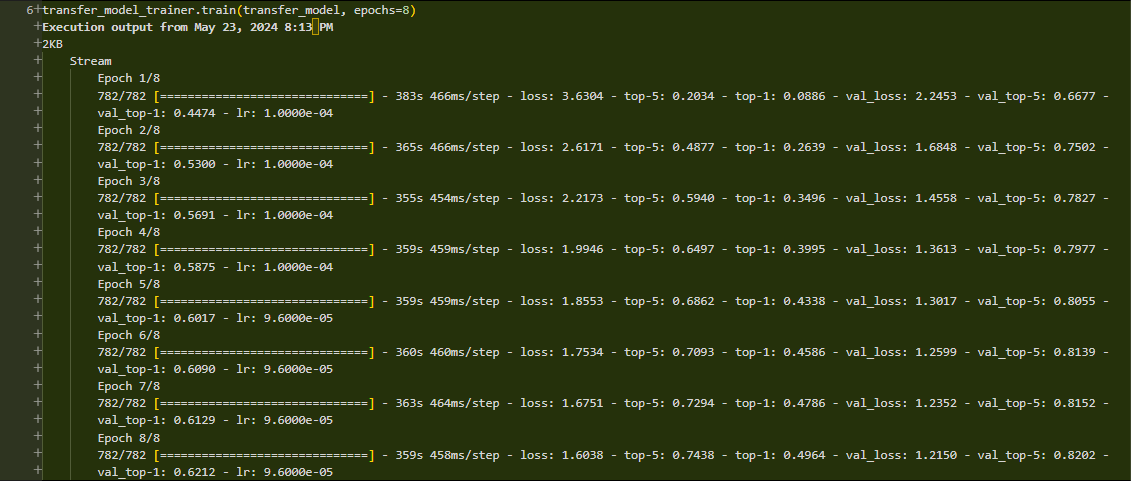

In [18]:
# Training on a subset of 100000 random images
# saving the model with the lowest validation loss
transfer_model_trainer = GoogLeNetTrainer(checkpoint_path="/content/drive/MyDrive/GoogLeNetTransfer3",
                                          batch_size=128)
loaded_transfer_model = tf.keras.models.load_model("/content/drive/MyDrive/GoogLeNetTransfer2")

# transfer_model_trainer.train(transfer_model, epochs=8)

The first 8 epochs have been successful with the overfitting issue, achieiving ~ 62% on the vaildation set on the 8th epoch.

#### Epochs 9-16

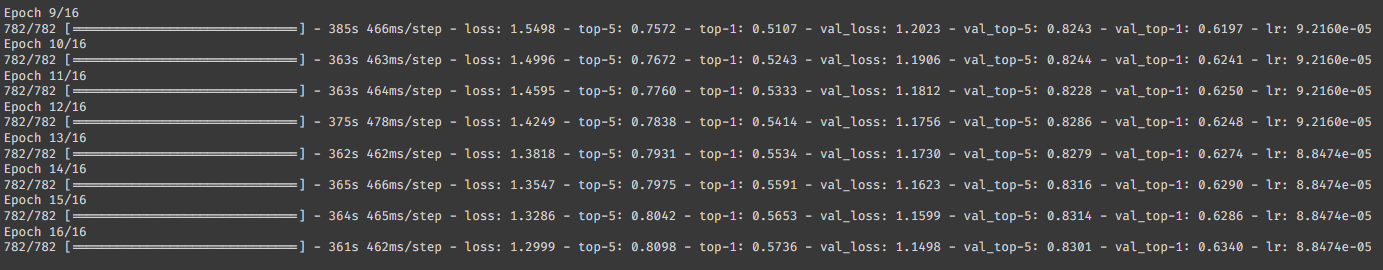

In [ ]:
# transfer_model_trainer.train(loaded_transfer_model, epochs=16, initial_epoch=8)

Epoch 9/16
782/782 [==============================] - 385s 466ms/step - loss: 1.5498 - top-5: 0.7572 - top-1: 0.5107 - val_loss: 1.2023 - val_top-5: 0.8243 - val_top-1: 0.6197 - lr: 9.2160e-05
Epoch 10/16
782/782 [==============================] - 363s 463ms/step - loss: 1.4996 - top-5: 0.7672 - top-1: 0.5243 - val_loss: 1.1906 - val_top-5: 0.8244 - val_top-1: 0.6241 - lr: 9.2160e-05
Epoch 11/16
782/782 [==============================] - 363s 464ms/step - loss: 1.4595 - top-5: 0.7760 - top-1: 0.5333 - val_loss: 1.1812 - val_top-5: 0.8228 - val_top-1: 0.6250 - lr: 9.2160e-05
Epoch 12/16
782/782 [==============================] - 375s 478ms/step - loss: 1.4249 - top-5: 0.7838 - top-1: 0.5414 - val_loss: 1.1756 - val_top-5: 0.8286 - val_top-1: 0.6248 - lr: 9.2160e-05
Epoch 13/16
782/782 [==============================] - 362s 462ms/step - loss: 1.3818 - top-5: 0.7931 - top-1: 0.5534 - val_loss: 1.1730 - val_top-5: 0.8279 - val_top-1: 0.6274 - lr: 8.8474e-05
Epoch 14/16
782/782 [==========

The next 8 epochs have not been as successful as the first 8, however the increase in accuracy has been minimal.

#### Epochs 17 - 20 [Using a smaller learning rate]
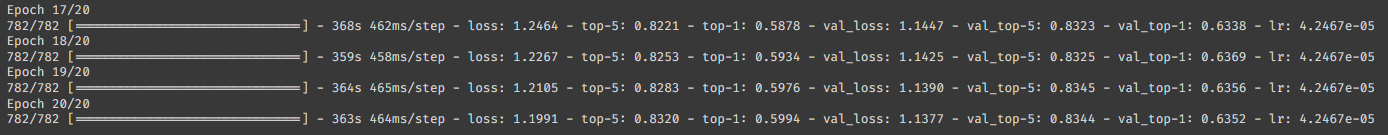

In [ ]:
transfer_model_trainer.train(loaded_transfer_model, epochs=20, initial_epoch=16)

Epoch 17/20
782/782 [==============================] - 368s 462ms/step - loss: 1.2464 - top-5: 0.8221 - top-1: 0.5878 - val_loss: 1.1447 - val_top-5: 0.8323 - val_top-1: 0.6338 - lr: 4.2467e-05
Epoch 18/20
782/782 [==============================] - 359s 458ms/step - loss: 1.2267 - top-5: 0.8253 - top-1: 0.5934 - val_loss: 1.1425 - val_top-5: 0.8325 - val_top-1: 0.6369 - lr: 4.2467e-05
Epoch 19/20
782/782 [==============================] - 364s 465ms/step - loss: 1.2105 - top-5: 0.8283 - top-1: 0.5976 - val_loss: 1.1390 - val_top-5: 0.8345 - val_top-1: 0.6356 - lr: 4.2467e-05
Epoch 20/20
782/782 [==============================] - 363s 464ms/step - loss: 1.1991 - top-5: 0.8320 - top-1: 0.5994 - val_loss: 1.1377 - val_top-5: 0.8344 - val_top-1: 0.6352 - lr: 4.2467e-05


Still no improvements to the validation set metrics

# Completed Training

In [20]:
loaded_transfer_model.evaluate(VALIDATION.take(100000))

313/313 [==============================] - 31s 99ms/step - loss: 1.1498 - top-5: 0.8301 - top-1: 0.6340


[1.1497974395751953, 0.8300999999046326, 0.6340000033378601]

The model:
validation_loss = 1.1497974395751953,
validation_top5 = 0.8300999999046326,
validation_top1 = 0.6340000033378601

## **Log**

**[22/12/2023 - 22:08]**
* Loaded Tiny Imagenet dataset
* Processed data and wrote code to produce a train and validation dataset

**[23/12/2023 - 22:22]**
* Found error in the processing of the labels of the data.
* Fixed error - edited code to that produces the train and validation set

**[25/12/2023 - 22:55]**
* Made all of the model internals
* Made the complete architecture of the model
* However needs reviewing as the parameter count is not the same as is in the paper.

**[26/12/2023]**
* Began trying to train the model
* Loss seems to be decreasing,
* However the accuracy does not seem to be increasing

**[03/01/2024 - 00:46]**
* Began the training of the model, accuracy issue has been fixed
* However there is a bug with the reduction in the leanring rate

**[03/01/2024 - 23:44]**
* Fixed Learning rate issue

**[07/01/2024 - 17:39]**
* Issue with training - due to the large size of the network, and the relatively small size of the dataset in comparison, the network seems to be overfitting.
* May need to employ regularisation techniques

**[26/01/2024 - 23:42]**
* Created a modified architecture with aditional dropout layers
* Began training network to test if the changes if effective.

**[04/02/2024 - 00:34]**
* Contined testing the effectiveness of different configurations of dropout layers

**[10/02/2024 - 23:59]**
* Found a "dropout" network variant of googlenet, which reduces the issue of overfitting, tested on 10 epochs.

**[16/02/2024 - 19:44]**
* Trained the altered "dropout" network with different l1 and l2 regularisation configurations, and after all tests, I concluded an optimal architecture that both reduced overfitting and ensured fast training time.

**[23/02/2024]**
* Began training the "dropout" network
* Failed

**[02/03/2024 - 21:08]**
* Made second attempt for training the "droput" network
* Failed once again. May use transfer learning.

**[22/03/2024 - 22:58]**
* Loaded a pretrained base inceptionv3 layer, and added additional dense layer to the end of it.
* Froze the layers of the base layer.

**[23/05/2024]**
* Trained the first 8 epochs of the Transfer Learning Model

**[06/06/2024 - 22:04]**
* Trained the next 8 epochs, model still not overfitting but has not shown any increase in accuracy.

**[19/06/2024 - 15:43]**
* Stopped model training due to pause in model accuracy.

Project Ended